# Preparing the sample data set

## About the Iris dataset
For the following tutorial, we will be working with the famous “Iris” dataset that has been deposited on the UCI machine learning repository
(https://archive.ics.uci.edu/ml/datasets/Iris).

**Reference:** Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.
The iris dataset contains measurements for 150 iris flowers from three different species.

### The three classes in the Iris dataset:

Iris-setosa (n=50)
Iris-versicolor (n=50)
Iris-virginica (n=50)
The four features of the Iris dataset:

sepal length in cm
sepal width in cm
petal length in cm
petal width in cm

In [1]:
# Create dictionary
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [2]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [17]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,[0,1,2,3]].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

Let's first convert the labels to numbers since it's easier to work with numerical values.

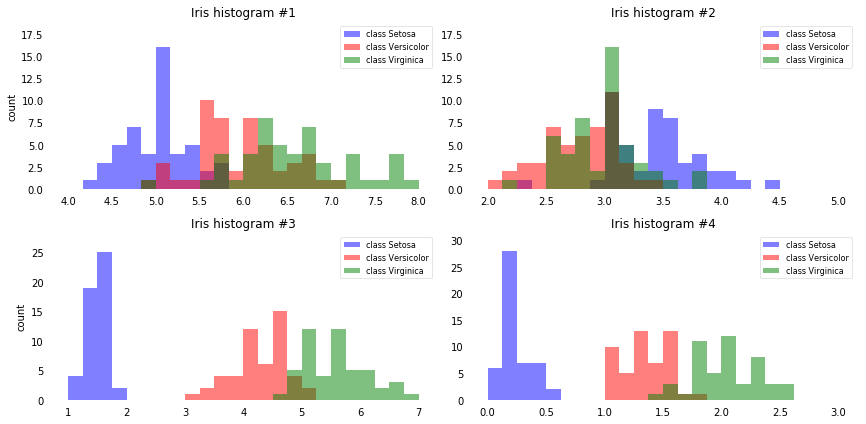

In [20]:
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax, cnt in zip(axes.ravel(), range(4)):
    
    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)
    
    # plot the histograms
    for lab, col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
               color=col,
               label='class %s' %label_dict[lab],
               bins=bins,
                alpha=0.5,)
    ylims = ax.get_ylim()
    
    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_label(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))
    
    # hide axis ticks
    ax.tick_params(axis='both', which='both', bottom='off', top='off',
                   labelbottom='on', left='off', right='off', labelleft='on')
    
    # remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    
axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()
plt.show()

There are some assumptions that need to be checked for LDA to work (even though it works reasonably well when these are violated):
* Normal distributed data
* Features that are statistically independent
* Identical covariance matrices for every class

Let's proceed and compute the d-dimensional mean vectors.

In [31]:
np.set_printoptions(precision=4) # denote the number of decimals

mean_vectors = [] # initiate empty list first
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0)) # axis=0 to compute over rows
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



Compute the scatter matrices, the within- and between-class matrices.

In [36]:
S_W = np.zeros((4,4))
for cl, mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4)) # scatter matrix for every class
    for row in X[y==cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [40]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))

for i, mean_vec in enumerate(mean_vectors):
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1)
    overall_mean = overall_mean.reshape(4,1)
    S_B += n* (mean_vec-overall_mean).dot((mean_vec-overall_mean).T)    

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


Next, we will solve the generalized eigenvalue problem for the matrix S−1WSB to obtain the linear discriminants.

In [42]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.4066]
 [-0.1647]
 [-0.2382]
 [ 0.8665]]
Eigenvalue 3: -9.44e-16

Eigenvector 4: 
[[ 0.137 ]
 [-0.3787]
 [-0.4432]
 [ 0.8009]]
Eigenvalue 4: 4.79e-15


Check the calculated eigenvalues and -vectors. It has to satisfy the following equation:<br>
Av=λv

In [43]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


Then, we sort the eigenvectors by decreasing eigenvalues. Higher eigenvalues indicate more information contained in thes vectors, therefore we sort ascending.

In [47]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.2719577997298
0.2775668638400503
4.791283021534857e-15
9.444145804886053e-16


Let's check the 'variance explained'.

In [49]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


Apparently the first eigenvalue contains most of the explained variance and we would not lose a lot of information by just plotting it on a 1-dimensional space. <br>
Next, we can choose the <i> k </i> eigenvectors with the largest eigenvalues. <br>
Now we need to construct our 4x2 dimensional eigenvector matrix W(these dimension in this case at least) to reduce the info to a 2-d level.

In [50]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


Now we take the matrix W and transform our samples using the equation: Y = X*W

In [51]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

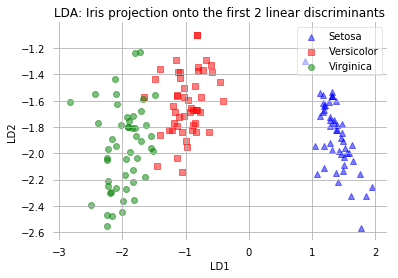

In [52]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()